## Session 3-1:<br> Rasterio / Zonalstats: Ghana Regional and District Average Heat Comparison

<hr style="border-top: 0.2px solid gray; margin-top: 12pt; margin-bottom: 0pt"></hr>

<img src="./assets/rasterio.png">

[Rasterio](https://rasterio.readthedocs.io/en/stable/#) is an open-source Python library that enables the use and maniplation of raster data. Most often used for remote-sensed or weather/climate data, raster data is a spatial grid in which each cell is ascribe a numeric or float point value. Often, raster values actually mean something physical (e.g. a global map of daily maximum temperature may be in °C). But they also can be used to classify grid cells (e.g. a value of 0, means ocean and a value of 1 means land). 

<img src="./assets/raster-vector.png" alt="rastervector" width="500"/>

As shown above, `Vector` data can be transformed into `raster` data, and vice versa. Like vector data, `raster` data must have spatial metadata that explains the geographic extent, crs, and projection, as well as things like `nan` values 

### Loading a Raster

Let's take a look at a `raster` dataset. This file contains an estimated **Maximum Daily Heat Index(himax)** values from [CHC-CMIP6](https://www.chc.ucsb.edu/data/chc-cmip6), a dataset from Climate Hazards Center at UC Santa Barbara. <ins>The `'himax'` is expressed as an apparent temperature in Celcius degrees to represent the perceived temperature based on air temperature and humidity.</ins>

The Climate Hazards Center (CHC) Coupled Model Intercomparison Project Phase 6 (CHC-CMIP6) was created to support the analysis of climate-related hazards over the recent past and in the near-future. This climate projection dataset contains global, daily gridded data for the observational (1983-2016) and projection (2030 and 2050) periods to be used in the identification and monitoring of hydroclimatic extremes

The temperature data within this dataset is from [CHIRTS-daily](https://www.chc.ucsb.edu/data/chirtsdaily), which leverages the temporal accuracy of weather stations with the spatial coverage of weather satellites to produce a continuous ~5km grid of daily maximum temperatures from 1983-2016. This is really important, because much of the planet does not have weather station data. In fact, about 4 billion people live more than 25 km from a weather station (see Cascade's paper in [Environmental Research Letters](https://iopscience.iop.org/article/10.1088/1748-9326/ac30c0/pdf)).

For the purpose of this workshop, we select only a HI image on 2016-07-01 and clipped it to the extent of Ghana for our analysis.

In [1]:
# load packages
import rasterio 
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from rasterstats import zonal_stats

First, let's load the `himax-2016-07-01-Ghana.tif` file

In [2]:
# specify base directory
base_dir = 'C:/Users/eqiluo1/02_Ghana_Workshop_Apr_2024/Climate-Health-Data-Science-Workshop'

# specify file path
fn = os.path.join(base_dir, 'Day3/data/himax-2016-07-01-Ghana.tif')

In [3]:
# open the raster dataset as python variable 
himax = rasterio.open(fn)

# print the type
print(type(himax))

<class 'rasterio.io.DatasetReader'>


The `rasterio` object is a `rasterio.io.DatasetReader` and has several attributes/methods that allow you to understand the dataset and access the data. But it is is not as straightforward as `GeoPandas DataFrames`. The `meta` attribute is the most useful. 

**QUESTION: What information does the meta give you?**

In [4]:
himax.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 91,
 'height': 130,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.05000000074505806, 0.0, -3.299997366964817,
        0.0, -0.05000000074505806, 11.199999123811722)}

Notice that the `meta` attribute is a Python `dictionary`, which means it can easily be accessed by `keys`. It can also be easily updated. 

In [5]:
print(himax.meta['dtype'])

float32


### Read and Write the data
Raster files (usually `GeoTiff`) often contain multiple `bands` or stacked arrays. In this case our raster only has one band. We can access it with the code below. Notice that the `band` is a 2-d numpy object with a shape of 2600 rows by 7200 columns.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [6]:
# read the first band of the raster file
himax.read(1)

array([[   39.391037,    39.493652,    39.57104 , ...,    40.486153,
           40.45363 ,    40.38176 ],
       [   39.23135 ,    39.2548  ,    39.391827, ...,    40.426243,
           40.37135 ,    40.256157],
       [   39.002495,    39.112907,    39.151245, ...,    40.52387 ,
           40.382553,    40.20173 ],
       ...,
       [-9999.      , -9999.      , -9999.      , ..., -9999.      ,
        -9999.      , -9999.      ],
       [-9999.      , -9999.      , -9999.      , ..., -9999.      ,
        -9999.      , -9999.      ],
       [-9999.      , -9999.      , -9999.      , ..., -9999.      ,
        -9999.      , -9999.      ]], dtype=float32)

In [7]:
# check what data type is hi.read(1)
print(type(himax.read(1)))

# print the shape of the data
print(himax.read(1).shape)

<class 'numpy.ndarray'>
(130, 91)


Let's plot it! You can use the [`plt.show()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) function to Display data as an image

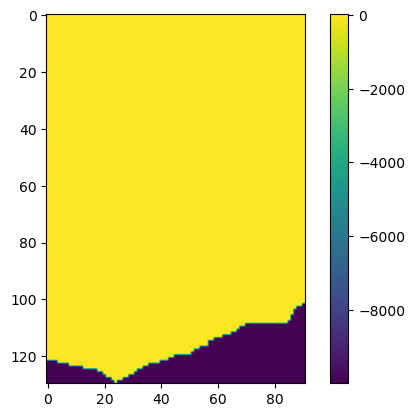

In [8]:
plt.imshow(himax.read(1))
plt.colorbar()

What's wrong with the image? Well it looks like the ocean values must be very small. From the printed array we know those ocean pixels are `-9999`, representing the `Nodata/NaN value`. Notice that in the meta data, nodata value is specified as -9999, but the ocean is still funny.<br> This is because `plt.imshow` is only being passed the `numpy array` object, not the meta data. 

One way to correctly visualize this raster will be to manual set the `vmin` and `vmax` parameteres.

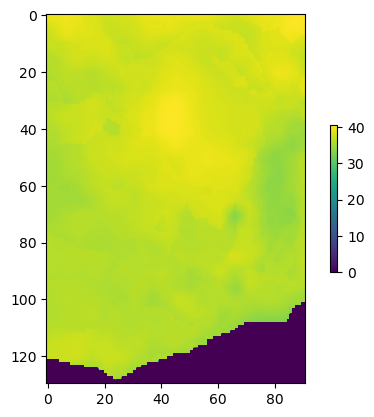

In [9]:
# For example, we can set the vmin to 0 for the visualization
plt.imshow(himax.read(1), vmin = 0 )

plt.colorbar(shrink = 0.4)

Another way to deal with NaN values when plotting raster data is to applying a `mask` to filter out the NaN pixels

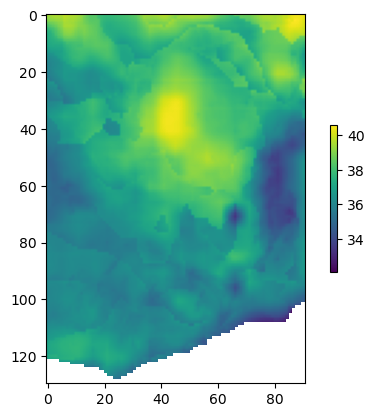

In [10]:
# First, read the himax as a numpy array
data = himax.read(1)

# Mask NoData values (-9999)
masked_data = np.ma.masked_where(data == -9999, data)

# Plotting the raster data
plt.imshow(masked_data) 
plt.colorbar(shrink=0.4)  # Adjust the size of the color bar

### We can also look at the distribution of the data
<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [11]:
# copy the array
arr = himax.read(1)
print(arr.shape)

# flatten it
arr_f = arr.flatten()
print(arr_f.shape)

(130, 91)
(11830,)


In [12]:
# Drop the NaN values - which is -9999
arr_f = arr_f[arr_f != -9999.]
print(arr_f.shape)

(10764,)


Text(0.5, 1.0, 'Distribution of Heat Index (℃) on July 1 2016')

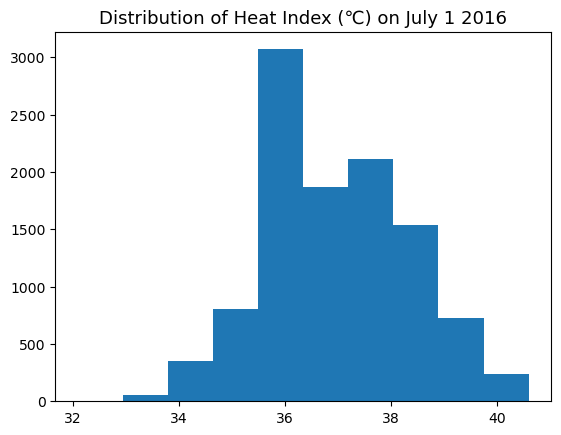

In [13]:
# Plot the histogram
plt.hist(arr_f);
plt.title('Distribution of Heat Index (℃) on July 1 2016', fontsize = 13)

### Raster Math
Because `raster` data are read by Python as 2-D `numpy arrays`, it is easy to preform mathmatical oppertations on them. The arrays must be the same size. In other words the rasters must align, the underlying raster files must have the same projection, .crs, spatial resolution, and spatial extent. 


For example, we can convert the heat index from *Celcius Degree* to *Farenheit Degree* using `numpy` for a finer temperature scale.

In [14]:
celsius_data = himax.read(1) 

# Replace -9999 with NaN
celsius_data = np.where(celsius_data == -9999, np.nan, celsius_data)

# Convert Celsius to Fahrenheit
fahrenheit_data = (celsius_data * 9/5) + 32

fahrenheit_data

array([[102.90387 , 103.08858 , 103.227875, ..., 104.87508 , 104.81653 ,
        104.68717 ],
       [102.61643 , 102.65864 , 102.90529 , ..., 104.767235, 104.66843 ,
        104.46108 ],
       [102.20449 , 102.40324 , 102.472244, ..., 104.94296 , 104.6886  ,
        104.36311 ],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)

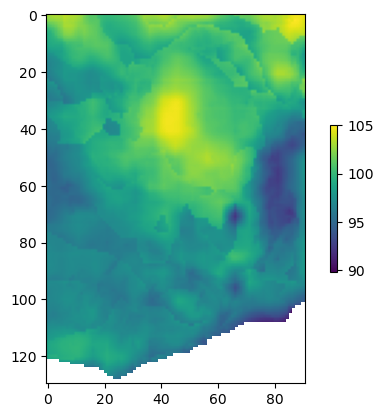

In [15]:
# Plotting the raster data
plt.imshow(fahrenheit_data)  # Set vmin to 0 to start color mapping from 0
plt.colorbar(shrink=0.4)  # Adjust the size of the color bar

In [16]:
output_path = './data/himax-2016-07-01-Ghana-farenheit.tif'

# Prepare to write the new data by copying the metadata
new_meta = himax.meta.copy()

# Write the converted data to a new raster file
with rasterio.open(output_path, 'w', **new_meta) as dst:
    dst.write(fahrenheit_data, 1)  # Write the Celsius data to the first band

### EXAMPLE: Ghana Regional and District Average Heat Index Caclculation
<hr style="border-top: 0.2px solid gray; margin-top: 12pt; margin-bottom: 0pt"></hr>

#### Objective
This tutorial aims to analyze and compare the average heat index across the different administrative regions and districts of Ghana. We will use geospatial data analysis techniques involving raster data and zonal statistics to explore heat variations and their implications.

#### Background
Understanding spatial variations in heat indices is crucial in assessing climate change impacts and aiding in effective planning and adaptation strategies. This tutorial will guide you through the processes of loading, processing, and analyzing raster and vector data using Python libraries such as `rasterio` and `rasterstats`.

**zonal statistics**: a method of summarizing and aggregating the raster values intersecting a vector geometry. For example, zonal statistics provides answers such as the mean precipitation or maximum elevation of an administrative unit.

#### Overview 
Typically, when you want to run an analysis like Zonnal Statistics, there are a few things asked for: 

- Input Zone layer
- Input raster Layer to Summarize
- Statistic Type

As an example, in our case, we will be working with: 

- 3 Polygon layers of Ghana Administrative Boundary at National, Regional and Distric Level
- Heat Index Map at 2016-07-01
- Average 

### Loading Vector Data

First, Let's load our <ins>admin boundary layer of Ghana</ins>, reterived from [Database of Global Administrative Areas(GADM)](https://gadm.org/) using `geopandas`. GADM provides maps and spatial data for all countries and their sub-divisions.

In [17]:
# Load the national admin boundary 
national = gpd.read_file('./data/gadm41_GHA_0.shp')

national

,GID_0,COUNTRY,geometry
0,GHA,Ghana,"POLYGON ((-1.77306 4.87536, -1.77318 4.87540, ..."


In [18]:
# Check out the columns of national admin boundary
national.columns

Index(['GID_0', 'COUNTRY', 'geometry'], dtype='object')

In [19]:
# Check out the shape of national vector dataframe
national.shape

(1, 3)

<Axes: >

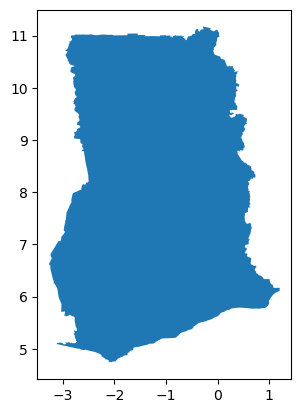

In [20]:
# Make a quick plot of Ghana national boundary
national.plot()

In [21]:
# Load the regional admin boundary 
regional = gpd.read_file('./data/gadm41_GHA_1.shp')
regional

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,GHA1_2,GHA,Ghana,Ahafo,NA,NA,Region,Region,NA,NA,GH-AF,"POLYGON ((-2.41599 6.65880, -2.41612 6.65887, ..."
1,GHA2_2,GHA,Ghana,Ashanti,NA,NA,Region,Region,NA,NA,GH-AH,"POLYGON ((-0.75537 6.91273, -0.75536 6.91270, ..."
2,GHA3_2,GHA,Ghana,Bono,NA,NA,Region,Region,NA,NA,GH-BO,"POLYGON ((-2.86623 6.85240, -2.86639 6.85248, ..."
3,GHA4_2,GHA,Ghana,Bono East,NA,NA,Region,Region,NA,NA,GH-BE,"POLYGON ((-1.43358 7.57346, -1.43520 7.56992, ..."
4,GHA5_2,GHA,Ghana,Central,NA,NA,Region,Region,NA,NA,GH-CP,"POLYGON ((-0.75619 5.71017, -0.75569 5.71023, ..."
5,GHA6_2,GHA,Ghana,Eastern,NA,NA,Region,Region,NA,NA,GH-EP,"POLYGON ((-0.42803 5.79268, -0.42826 5.79276, ..."
6,GHA7_2,GHA,Ghana,Greater Accra,NA,NA,Region,Region,NA,NA,GH-AA,"POLYGON ((-0.22106 5.52982, -0.22130 5.52978, ..."
7,GHA8_2,GHA,Ghana,North East,NA,NA,Region,Region,NA,NA,GH-NE,"POLYGON ((-1.58674 10.08098, -1.58688 10.08111..."
8,GHA9_2,GHA,Ghana,Northern,NA,NA,Region,Region,NA,NA,GH-NP,"POLYGON ((0.10764 8.49494, 0.11230 8.49266, 0...."
9,GHA10_2,GHA,Ghana,Oti,NA,NA,Region,Region,NA,NA,GH-OT,"POLYGON ((0.52036 7.51176, 0.52051 7.51176, 0...."


In [22]:
# Check out the columns of national admin boundary
regional.columns

Index(['GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1', 'NL_NAME_1',
       'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'geometry'],
      dtype='object')

In [23]:
# Check out the shape of national vector dataframe
regional.shape

(16, 12)

<Axes: >

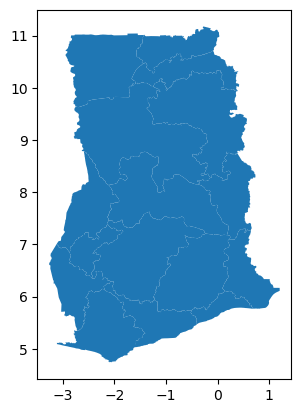

In [24]:
# Make a quick plot of Ghana national boundary
regional.plot()

In [25]:
# Load the district admin boundary 
district = gpd.read_file('./data/gadm41_GHA_2.shp')

district

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,GHA1.1_2,GHA,Ghana,GHA1_2,Ahafo,NA,Asunafo North,NA,NA,Municipality,Municipality,NA,NA,"POLYGON ((-2.87750 6.65303, -2.87756 6.65323, ..."
1,GHA1.2_2,GHA,Ghana,GHA1_2,Ahafo,NA,Asunafo South,NA,NA,District,District,NA,NA,"POLYGON ((-2.83203 6.63043, -2.83157 6.63067, ..."
2,GHA1.3_2,GHA,Ghana,GHA1_2,Ahafo,NA,Asutifi North,NA,NA,District,District,NA,NA,"POLYGON ((-2.49059 7.21745, -2.49002 7.21670, ..."
3,GHA1.4_2,GHA,Ghana,GHA1_2,Ahafo,NA,Asutifi South,NA,NA,District,District,NA,NA,"POLYGON ((-2.49209 6.76880, -2.49225 6.77017, ..."
4,GHA1.5_2,GHA,Ghana,GHA1_2,Ahafo,NA,Tano North,NA,NA,Municipality,Municipality,NA,NA,"POLYGON ((-2.06494 7.31951, -2.06496 7.31940, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,GHA16.5_2,GHA,Ghana,GHA16_2,Western North,NA,Bodi,NA,NA,District,District,NA,NA,"POLYGON ((-2.94824 6.16543, -2.94897 6.16539, ..."
256,GHA16.6_2,GHA,Ghana,GHA16_2,Western North,NA,Juaboso,NA,NA,District,District,NA,NA,"POLYGON ((-3.03136 6.22585, -3.03174 6.22619, ..."
257,GHA16.8_2,GHA,Ghana,GHA16_2,Western North,NA,Sefwi-Akontombra,NA,NA,District,District,NA,NA,"POLYGON ((-2.55840 5.97867, -2.55860 5.97863, ..."
258,GHA16.7_2,GHA,Ghana,GHA16_2,Western North,NA,Sefwi-Wiawso,NA,NA,Municipality,Municipality,NA,NA,"POLYGON ((-2.71883 6.39646, -2.71893 6.39664, ..."


In [26]:
# Check out the columns of national admin boundary
district.columns

Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry'],
      dtype='object')

In [27]:
# Check out the shape of national vector dataframe
district.shape

(260, 14)

<Axes: >

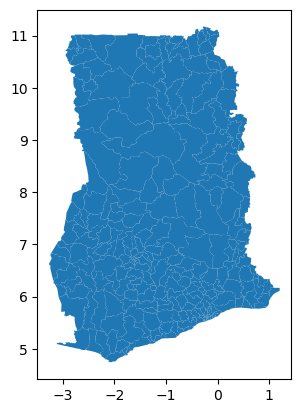

In [28]:
# Make a quick plot of Ghana national boundary
district.plot()

### Loading Raster Data
Next, let's the daily maximum heat index raster data using `rasterio`.

In [29]:
# specify file path
fn = os.path.join(base_dir, 'Day3/data/himax-2016-07-01-Ghana.tif')
hi_max = rasterio.open(fn)

You can also use the [`show()`](https://rasterio.readthedocs.io/en/latest/topics/plotting.html) funtion from `Rasterio` to plot raster file, which will recognize the NaN value from the meta data and haldle it when plotting. Run the following code and check the result:

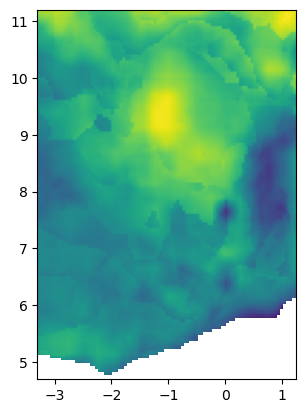

<Axes: >

In [30]:
from rasterio.plot import show

show(hi_max)

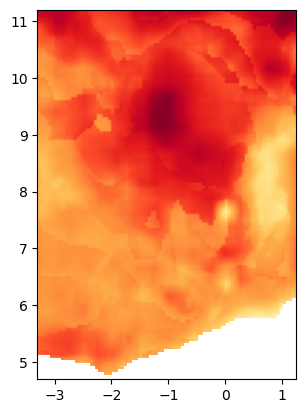

<Axes: >

In [31]:
# you can also pass the 'cmap' parameter to change the color scheme
show(hi_max, cmap = 'YlOrRd')


### Aligning Coordinate Reference Systems (CRS)
It's crucial that <ins>the raster and vector data share the same CRS</ins> to accurately overlay and analyze them. Here's how you can check and align CRS.


In [32]:
# Check CRS of both datasets
print("Raster CRS:", hi_max.crs)
print("Vector CRS:", national.crs)
print("Vector CRS:", regional.crs)
print("Vector CRS:", district.crs)

Raster CRS: EPSG:4326
Vector CRS: EPSG:4326
Vector CRS: EPSG:4326
Vector CRS: EPSG:4326


If the raster and vector files are not in the same CRS, a reprojection is required.

#### Introduction to Functions in Python
Before we officially run the zonal statistic, let's briefly learn about Function in Python - they are your best friends who makes coding easier! 

What is a Function?<br>
In Python, a function is <ins>a reusable block of code that performs a specific task</ins>. Functions help break our program into smaller and modular chunks. As our program grows larger and larger, functions make it more organized and manageable. Furthermore, it avoids repetition and makes the code reusable.

You define functions using the `def` key word and you use `()` to state the parameters (or arguments) that the function needs to be passed to be implemented. Not all functions require parameters. A few things to note: 
1. Variables assigned within a function are local (e.g. exist within the function) and those outside functions are global (e.g. accessable by all parts of your code). 
2. To get the output of a function, you must use the key word `return`


In [33]:
def greet(name):
    """This function greets to the person passed in as a parameter"""
    print("Hello, " + name + "!")

In [34]:
# try to greet someone 
greet('Ghana')

Hello, Ghana!


#### Calculating Zonal Statistics
From `rasterstats`, we can use the [`zonal_stats`](https://pythonhosted.org/rasterstats/manual.html) function to build our own defined function `zonal` to easily compute the average heat index per geographic area we want. This function will encapsulate all the necessary steps required to perform this computation and can be reused for any raster or vector data input with different statistics.


In [35]:
def zonal(rst_in, polys_in, do_stats):
    """Function will run zonal stats on a raster and a set of polygons. All touched is set to True by default.
    
    Args:
        rst_in (str): File name/path of raster to run zonal stats on.
        polys_in (GeoDataFrame): GeoDataFrame of polygons (e.g., administrative boundaries).
        do_stats (str): Stats to compute, see rasterstats package for documentation (e.g., 'mean', 'sum').
    
    Returns:
        GeoDataFrame: A GeoDataFrame with the results of the zonal statistics.
    """
    # Ensure the polygons are in the same CRS as the raster
    # Note: It's good practice to read the raster's CRS dynamically rather than hardcoding it
    with rasterio.open(rst_in) as src:
        raster_crs = src.crs
    polys_in = polys_in.to_crs(raster_crs)
    
    # Run Zonal Stats
    zs_feats = zonal_stats(polys_in, rst_in, stats=do_stats, geojson_out=True, all_touched=True)
    
    # Turn into GeoDataFrame and set CRS
    zgdf = gpd.GeoDataFrame.from_features(zs_feats)
    zgdf.crs = polys_in.crs  # Ensuring the resulting GeoDataFrame retains the original CRS
    
    return zgdf


First, let's calculate the average maximum heat index at the national scale

In [36]:
# Load your vector data 
polys_in = national[['COUNTRY', 'geometry']]

# Specify the raster file and the statistic you want to compute
rst_in = os.path.join(base_dir, 'Day3/data/himax-2016-07-01-Ghana.tif')
do_stats = 'mean'  # This could be 'sum', 'mean', 'max', etc.

# Run the zonal statistics function
national = zonal(rst_in, polys_in, do_stats)

In [37]:
# check the result
national

,geometry,COUNTRY,mean
0,"POLYGON ((-1.77306 4.87536, -1.77318 4.87540, ...",Ghana,37.048292


In [38]:
print('the average daily maximun heat index at national level for Ghana is ' + str(national['mean'].iloc[0]))

the average daily maximun heat index at national level for Ghana is 37.04829161028417


Second, let's calculate the average maximum heat index at the regional scale

In [39]:
# Load your vector data 
polys_in = regional

# Specify the raster file and the statistic you want to compute
rst_in = os.path.join(base_dir, 'Day3/data/himax-2016-07-01-Ghana.tif')
do_stats = 'mean'  # This could be 'sum', 'mean', 'max', etc.

# Run the zonal statistics function
regional = zonal(rst_in, polys_in, do_stats)

In [40]:
regional

,geometry,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,mean
0,"POLYGON ((-2.41599 6.65880, -2.41612 6.65887, ...",GHA1_2,GHA,Ghana,Ahafo,NA,NA,Region,Region,NA,NA,GH-AF,35.949744
1,"POLYGON ((-0.75537 6.91273, -0.75536 6.91270, ...",GHA2_2,GHA,Ghana,Ashanti,NA,NA,Region,Region,NA,NA,GH-AH,36.131965
2,"POLYGON ((-2.86623 6.85240, -2.86639 6.85248, ...",GHA3_2,GHA,Ghana,Bono,NA,NA,Region,Region,NA,NA,GH-BO,36.157753
3,"POLYGON ((-1.43358 7.57346, -1.43520 7.56992, ...",GHA4_2,GHA,Ghana,Bono East,NA,NA,Region,Region,NA,NA,GH-BE,37.370395
4,"POLYGON ((-0.75619 5.71017, -0.75569 5.71023, ...",GHA5_2,GHA,Ghana,Central,NA,NA,Region,Region,NA,NA,GH-CP,35.830896
5,"POLYGON ((-0.42803 5.79268, -0.42826 5.79276, ...",GHA6_2,GHA,Ghana,Eastern,NA,NA,Region,Region,NA,NA,GH-EP,36.217173
6,"POLYGON ((-0.22106 5.52982, -0.22130 5.52978, ...",GHA7_2,GHA,Ghana,Greater Accra,NA,NA,Region,Region,NA,NA,GH-AA,34.822802
7,"POLYGON ((-1.58674 10.08098, -1.58688 10.08111...",GHA8_2,GHA,Ghana,North East,NA,NA,Region,Region,NA,NA,GH-NE,37.932098
8,"POLYGON ((0.10764 8.49494, 0.11230 8.49266, 0....",GHA9_2,GHA,Ghana,Northern,NA,NA,Region,Region,NA,NA,GH-NP,38.444851
9,"POLYGON ((0.52036 7.51176, 0.52051 7.51176, 0....",GHA10_2,GHA,Ghana,Oti,NA,NA,Region,Region,NA,NA,GH-OT,36.465516


we can now plot the average maximum heat index at regional level 

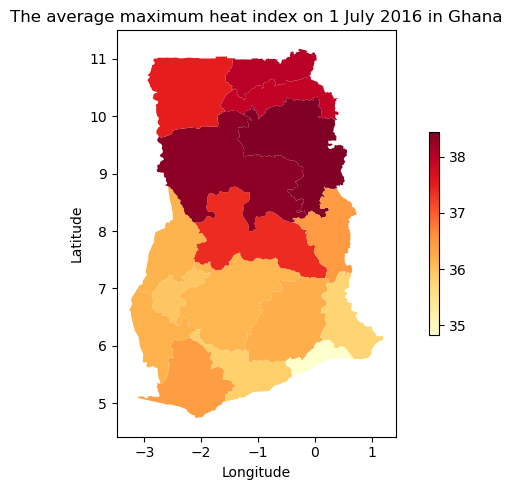

In [41]:
# Initialize the plot
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Plot the locations of the household survey with the rural/urban column defining the colors
regional.plot(column='mean', cmap = 'YlOrRd', legend=True, legend_kwds={'shrink': 0.5}, ax=ax)


# Set plot title and labels
plt.title('The average maximum heat index on 1 July 2016 in Ghana')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

Looks good? Now let's do this at the district level.

In [42]:
# Load your vector data 
polys_in = district

# Specify the raster file and the statistic you want to compute
rst_in = os.path.join(base_dir, 'Day3/data/himax-2016-07-01-Ghana.tif')
do_stats = 'mean'  # This could be 'sum', 'mean', 'max', etc.

# Run the zonal statistics function
district = zonal(rst_in, polys_in, do_stats)

In [43]:
district

,geometry,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,mean
0,"POLYGON ((-2.87750 6.65303, -2.87756 6.65323, ...",GHA1.1_2,GHA,Ghana,GHA1_2,Ahafo,NA,Asunafo North,NA,NA,Municipality,Municipality,NA,NA,36.142916
1,"POLYGON ((-2.83203 6.63043, -2.83157 6.63067, ...",GHA1.2_2,GHA,Ghana,GHA1_2,Ahafo,NA,Asunafo South,NA,NA,District,District,NA,NA,36.005467
2,"POLYGON ((-2.49059 7.21745, -2.49002 7.21670, ...",GHA1.3_2,GHA,Ghana,GHA1_2,Ahafo,NA,Asutifi North,NA,NA,District,District,NA,NA,35.880259
3,"POLYGON ((-2.49209 6.76880, -2.49225 6.77017, ...",GHA1.4_2,GHA,Ghana,GHA1_2,Ahafo,NA,Asutifi South,NA,NA,District,District,NA,NA,36.127435
4,"POLYGON ((-2.06494 7.31951, -2.06496 7.31940, ...",GHA1.5_2,GHA,Ghana,GHA1_2,Ahafo,NA,Tano North,NA,NA,Municipality,Municipality,NA,NA,35.669542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,"POLYGON ((-2.94824 6.16543, -2.94897 6.16539, ...",GHA16.5_2,GHA,Ghana,GHA16_2,Western North,NA,Bodi,NA,NA,District,District,NA,NA,36.238803
256,"POLYGON ((-3.03136 6.22585, -3.03174 6.22619, ...",GHA16.6_2,GHA,Ghana,GHA16_2,Western North,NA,Juaboso,NA,NA,District,District,NA,NA,36.103508
257,"POLYGON ((-2.55840 5.97867, -2.55860 5.97863, ...",GHA16.8_2,GHA,Ghana,GHA16_2,Western North,NA,Sefwi-Akontombra,NA,NA,District,District,NA,NA,36.264289
258,"POLYGON ((-2.71883 6.39646, -2.71893 6.39664, ...",GHA16.7_2,GHA,Ghana,GHA16_2,Western North,NA,Sefwi-Wiawso,NA,NA,Municipality,Municipality,NA,NA,36.023353


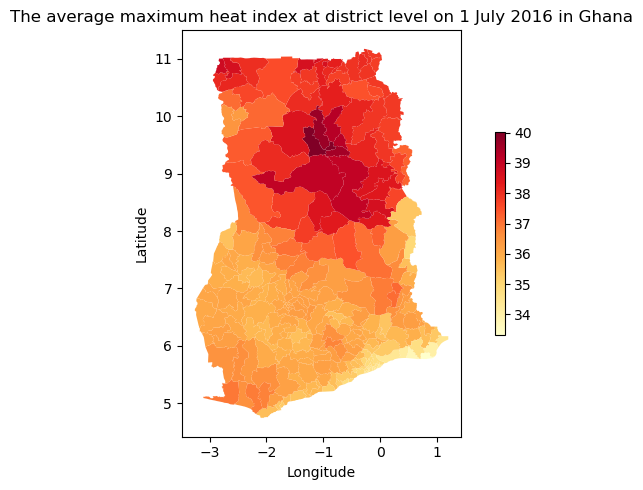

In [44]:
# Initialize the plot
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Plot the locations of the household survey with the rural/urban column defining the colors
district.plot(column='mean', cmap = 'YlOrRd', legend=True, legend_kwds={'shrink': 0.5}, ax=ax)

# Set plot title and labels
plt.title('The average maximum heat index at district level on 1 July 2016 in Ghana')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

Besides mean, there are other statistics that can be calculated by `zonal_stats()` function: 

By default, the zonal_stats function will return the following statistics

- min
- max
- mean
- count

Optionally, these statistics are also available.

- sum
- std
- median
- majority
- minority
- unique
- range
- nodata


#### What's next...?
After we calculate the average heat index of each district, there are many ways to use this information. For example, we can <ins>identify the districts with extreme heat conditions and prioritize them.</ins> 

In this tutorial, we'll define "extreme" heat conditions as *being above the 90th percentile of the mean heat index across all districts.* We will identify which districts consistently experience higher heat indices and might require additional attention for heat-related health advisories and urban planning.

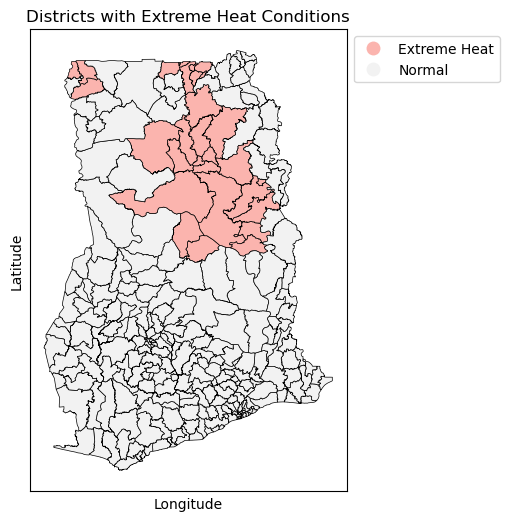

In [45]:
# Calculate the 90th percentile of the mean heat index
threshold = np.percentile(district['mean'], 90)

# Create a new column 'heat_class' that labels districts based on the heat index threshold
district['heat_class'] = np.where(district['mean'] >= threshold, 'Extreme Heat', 'Normal')


# Plotting all districts with custom colors based on 'heat_class'
fig, ax = plt.subplots(figsize=(7, 6))
district.plot(ax=ax, cmap='Pastel1', legend=True, edgecolor='black', 
              linewidth=0.5, column='heat_class',
              legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)})

# Adding title and labels
plt.title('Districts with Extreme Heat Conditions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Removing the x and y axis for a cleaner look
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()


#### Now you can save your geopandas with calculated mean maximum heat index at different scale

In [ ]:
# as you specify
output_path = '.../..../output_filename.shp' 

# Save the GeoDataFrame as a Shapefile
#district.to_file(output_path)

If you only need the attribute data and not the geometry, you can save it as a CSV:

In [ ]:
# as you specify
output_path = '.../..../output_filename.csv' 

## Save the GeoDataFrame as a CSV
#district.to_csv(output_path, index=False)